### **Input**

In [21]:
import time

In [22]:
import numpy as np

n=50

results = np.zeros((n,n**2))
r = 4

# m = round(n*n*)
C = np.random.randn(n,r)
D = np.random.randn(r,n)
M = np.dot(C,D)

# Thuật toán điểm trong 

In [23]:
from cvxopt import matrix, spmatrix, normal, setseed, blas, lapack, solvers
# import nucnrm

from tqdm import tqdm

In [24]:
import matplotlib.pyplot as plt

In [25]:
from cvxopt import matrix, spmatrix, sqrt, sparse, mul
from cvxopt import base, blas, lapack, solvers, misc 

__all__ = [ 'nrmapp' ]

def nrmapp(A, B, C = None, d = None, G = None, h = None): 
    """

    Solves the regularized nuclear norm approximation problem 
    
        minimize    || A(x) + B ||_* + 1/2 x'*C*x + d'*x
        subject to  G*x <= h

    and its dual

        maximize    -h'*z + tr(B'*Z) - 1/2 v'*C*v 
        subject to  d + G'*z + A'(Z) = C*v 
                    z >= 0
                    || Z || <= 1.

    A(x) is a linear mapping that maps n-vectors x to (p x q)-matrices A(x).

    ||.||_* is the nuclear norm (sum of singular values).  

    A'(Z) is the adjoint mapping of A(x).

    ||.|| is the maximum singular value norm.


    INPUT 

    A       real dense or sparse matrix of size (p*q, n).  Its columns are
            the coefficients A_i of the mapping 

                A: reals^n --> reals^pxq,   A(x) = sum_i=1^n x_i * A_i, 
                     
            stored in column-major order, as p*q-vectors.
        
    B       real dense or sparse matrix of size (p, q), with p >= q.
    
    C       real symmetric positive semidefinite dense or sparse matrix of 
            order n.  Only the lower triangular part of C is accessed.
            The default value is a zero matrix.

    d       real dense matrix of size (n, 1).  The default value is a zero
            vector.
    
    G       real dense or sparse matrix of size (m, n), with m >= 0.  
            The default value is a matrix of size (0, n).
    
    h       real dense matrix of size (m, 1).  The default value is a 
            matrix of size (0, 1).


    OUTPUT

    status  'optimal', 'primal infeasible', or 'unknown'. 

    x       'd' matrix of size (n, 1) if status is 'optimal'; 
            None otherwise.

    z       'd' matrix of size (m, 1) if status is 'optimal' or 'primal 
            infeasible'; None otherwise.

    Z       'd' matrix of size (p, q) if status is 'optimal' or 'primal
            infeasible'; None otherwise.


    If status is 'optimal', then x, z, Z are approximate solutions of the
    optimality conditions

        C * x  + G' * z + A'(Z) + d = 0  
        G * x <= h 
        z >= 0,  || Z || < = 1
        z' * (h - G*x) = 0
        tr (Z' * (A(x) + B)) = || A(x) + B ||_*.

    The last (complementary slackness) condition can be replaced by the
    following.  If the singular value decomposition of A(x) + B is

        A(x) + B = [ U1  U2 ] * diag(s, 0) * [ V1  V2 ]',

    with s > 0, then

        Z = U1 * V1' + U2 * W * V2',  || W || <= 1. 


    If status is 'primal infeasible', then Z = 0 and z is a certificate of
    infeasibility for the inequalities G * x <= h, i.e., a vector that
    satisfies

        h' * z = 1,  G' * z = 0,  z >= 0.

    """

    if type(B) not in (matrix, spmatrix) or B.typecode != 'd':
        raise TypeError("B must be a real dense or sparse matrix")
    p, q = B.size
    if p < q:
        raise ValueError("row dimension of B must be greater than or "\
            "equal to column dimension")
    
    if type(A) not in (matrix, spmatrix) or A.typecode != 'd' or \
        A.size[0] != p*q:
        raise TypeError("A must be a real dense or sparse matrix with "\
            "p*q rows if B has size (p, q)")
    n = A.size[1]
    
    if G is None:  G = spmatrix([], [], [], (0, n))
    if h is None:  h = matrix(0.0, (0, 1))
    if type(h) is not matrix or h.typecode != 'd' or h.size[1] != 1:
        raise TypeError("h must be a real dense matrix with one column")
    m = h.size[0]
    if type(G) not in (matrix, spmatrix) or G.typecode != 'd' or \
        G.size != (m, n):
        raise TypeError("G must be a real dense matrix or sparse matrix "\
            "of size (m, n) if h has length m and A has n columns")
       
    if C is None: C = spmatrix(0.0, [], [], (n,n))
    if d is None: d = matrix(0.0, (n, 1))
    if type(C) not in (matrix, spmatrix) or C.typecode != 'd' or \
        C.size != (n,n):
        raise TypeError("C must be real dense or sparse matrix of size "\
            "(n, n) if A has n columns")
    if type(d) is not matrix or d.typecode != 'd' or d.size != (n,1):
        raise TypeError("d must be a real matrix of size (n, 1) if A has "\
            "n columns")


    # The problem is solved as a cone program
    #
    #     minimize    (1/2) * x'*C*x + d'*x  + (1/2) * (tr X1 + tr X2)
    #     subject to  G*x <= h
    #                 [ X1         (A(x) + B)' ]
    #                 [ A(x) + B   X2          ]  >= 0.
    #
    # The primal variable is stored as a list [ x, X1, X2 ].

    def xnewcopy(u): 
        return [ matrix(u[0]), matrix(u[1]), matrix(u[2]) ]
    def xdot(u,v):
        return blas.dot(u[0], v[0]) + misc.sdot2(u[1], v[1]) + \
            misc.sdot2(u[2], v[2])
    def xscal(alpha, u):
        blas.scal(alpha, u[0])
        blas.scal(alpha, u[1])
        blas.scal(alpha, u[2])
    def xaxpy(u, v, alpha = 1.0):
        blas.axpy(u[0], v[0], alpha)
        blas.axpy(u[1], v[1], alpha)
        blas.axpy(u[2], v[2], alpha)

    def Pf(u, v, alpha = 1.0, beta = 0.0):  
        base.symv(C, u[0], v[0], alpha = alpha, beta = beta)
        blas.scal(beta, v[1])
        blas.scal(beta, v[2])

    c = [ d, matrix(0.0, (q,q)), matrix(0.0, (p,p)) ]
    c[1][::q+1] = 0.5
    c[2][::p+1] = 0.5


    # If V is a p+q x p+q matrix 
    #
    #         [ V11  V12 ]
    #     V = [          ]
    #         [ V21  V22 ] 
    #
    # with V11 q x q,  V21 p x q, V12 q x p, and V22 p x p, then I11, I21,
    # I22 are the index sets defined by
    #
    #     V[I11] = V11[:],  V[I21] = V21[:],  V[I22] = V22[:].
    #

    I11 = matrix([ i + j*(p+q) for j in range(q) for i in range(q) ])
    I21 = matrix([ q + i + j*(p+q) for j in range(q) for i in range(p) ])
    I22 = matrix([ (p+q)*q + q + i + j*(p+q) for j in range(p) for 
       i in range(p) ])

    dims = {'l': m, 'q': [], 's': [p+q]}
    hh = matrix(0.0, (m + (p+q)**2, 1))
    hh[:m] = h
    hh[m + I21] = B[:]

    def Gf(u, v, alpha = 1.0, beta = 0.0, trans = 'N'):

        if trans == 'N':
 
            # v[:m] := alpha * G * u[0] + beta * v[:m]
            base.gemv(G, u[0], v, alpha = alpha, beta = beta)

            # v[m:] := alpha * [-u[1],  -A(u[0])';  -A(u[0]), -u[2]]
            #          + beta * v[m:]
            blas.scal(beta, v, offset = m)
            v[m + I11] -= alpha * u[1][:]
            v[m + I21] -= alpha * A * u[0]
            v[m + I22] -= alpha * u[2][:]

        else:   
           
            # v[0] := alpha * ( G.T * u[:m] - 2.0 * A.T * u[m + I21] )
            #         + beta v[1]
            base.gemv(G, u, v[0], trans = 'T', alpha = alpha, beta = beta)  
            base.gemv(A, u[m + I21], v[0], trans = 'T', alpha = -2.0*alpha,
                beta = 1.0)

            # v[1] := -alpha * u[m + I11] + beta * v[1]
            blas.scal(beta, v[1])
            blas.axpy(u[m + I11], v[1], alpha = -alpha)

            # v[2] := -alpha * u[m + I22] + beta * v[2]
            blas.scal(beta, v[2])
            blas.axpy(u[m + I22], v[2], alpha = -alpha)


    def Af(u, v, alpha = 1.0, beta = 0.0, trans = 'N'):
        if trans == 'N':
            pass
        else:
            blas.scal(beta, v[0])
            blas.scal(beta, v[1])
            blas.scal(beta, v[2])


    L1 = matrix(0.0, (q, q))
    L2 = matrix(0.0, (p, p))
    T21 = matrix(0.0, (p, q))
    s = matrix(0.0, (q, 1))
    SS = matrix(0.0, (q, q))
    V1 = matrix(0.0, (q, q))
    V2 = matrix(0.0, (p, p))
    As = matrix(0.0, (p*q, n))
    As2 = matrix(0.0, (p*q, n))
    tmp = matrix(0.0, (p, q))
    a = matrix(0.0, (p+q, p+q))
    H = matrix(0.0, (n,n))
    Gs = matrix(0.0, (m, n))
    Q1 = matrix(0.0, (q, p+q))
    Q2 = matrix(0.0, (p, p+q))
    tau1 = matrix(0.0, (q,1))
    tau2 = matrix(0.0, (p,1))
    bz11 = matrix(0.0, (q,q))
    bz22 = matrix(0.0, (p,p))
    bz21 = matrix(0.0, (p,q))

    # Suppose V = [V1; V2] is p x q with V1 q x q.  If v = V[:] then
    # v[Itriu] are the strict upper triangular entries of V1 stored
    # columnwise.
    Itriu = [ i + j*p for j in range(1,q) for i in range(j) ]

    # v[Itril] are the strict lower triangular entries of V1 stored rowwise.
    Itril = [ j + i*p for j in range(1,q) for i in range(j) ]

    # v[Idiag] are the diagonal entries of V1.
    Idiag = [ i*(p+1) for i in range(q) ]

    # v[Itriu2] are the upper triangular entries of V1, with the diagonal
    # entries stored first, followed by the strict upper triangular entries
    # stored columnwise.
    Itriu2 = Idiag + Itriu

    # If V is a q x q matrix and v = V[:], then v[Itril2] are the strict
    # lower triangular entries of V stored columnwise and v[Itril3] are
    # the strict lower triangular entries stored rowwise.
    Itril2 = [ i + j*q for j in range(q) for i in range(j+1,q) ]
    Itril3 = [ i + j*q for i in range(q) for j in range(i) ]

    P = spmatrix(0.0, Itriu, Itril, (p*q, p*q))
    D = spmatrix(1.0, range(p*q), range(p*q))
    DV = matrix(1.0, (p*q, 1))


    def F(W):
        """
        Create a solver for the linear equations

                                C * ux + G' * uzl - 2*A'(uzs21) = bx
                                                         -uzs11 = bX1
                                                         -uzs22 = bX2
                                            G * ux - Dl^2 * uzl = bzl
            [ -uX1   -A(ux)' ]          [ uzs11 uzs21' ]     
            [                ] - r*r' * [              ] * r*r' = bzs
            [ -A(ux) -uX2    ]          [ uzs21 uzs22  ]

        where Dl = diag(W['l']), r = W['r'][0].  

        On entry, x = (bx, bX1, bX2) and z = [ bzl; bzs[:] ].
        On exit, x = (ux, uX1, uX2) and z = [ Dl*uzl; (r'*uzs*r)[:] ].


        1. Compute matrices V1, V2 such that (with T = r*r')
        
               [ V1   0   ] [ T11  T21' ] [ V1'  0  ]   [ I  S' ]
               [          ] [           ] [         ] = [       ]
               [ 0    V2' ] [ T21  T22  ] [ 0    V2 ]   [ S  I  ]
        
           and S = [ diag(s); 0 ], s a positive q-vector.

        2. Factor the mapping X -> X + S * X' * S:

               X + S * X' * S = L( L'( X )). 

        3. Compute scaled mappings: a matrix As with as its columns the 
           coefficients of the scaled mapping 

               L^-1( V2' * A() * V1' ) 

           and the matrix Gs = Dl^-1 * G.

        4. Cholesky factorization of H = C + Gs'*Gs + 2*As'*As.

        """


        # 1. Compute V1, V2, s.  

        r = W['r'][0]

        # LQ factorization R[:q, :] = L1 * Q1.
        lapack.lacpy(r, Q1, m = q)
        lapack.gelqf(Q1, tau1)
        lapack.lacpy(Q1, L1, n = q, uplo = 'L')
        lapack.orglq(Q1, tau1)

        # LQ factorization R[q:, :] = L2 * Q2.
        lapack.lacpy(r, Q2, m = p, offsetA = q)
        lapack.gelqf(Q2, tau2)
        lapack.lacpy(Q2, L2, n = p, uplo = 'L')
        lapack.orglq(Q2, tau2)


        # V2, V1, s are computed from an SVD: if
        # 
        #     Q2 * Q1' = U * diag(s) * V',
        #
        # then V1 = V' * L1^-1 and V2 = L2^-T * U.
    
        # T21 = Q2 * Q1.T  
        blas.gemm(Q2, Q1, T21, transB = 'T')

        # SVD T21 = U * diag(s) * V'.  Store U in V2 and V' in V1.
        lapack.gesvd(T21, s, jobu = 'A', jobvt = 'A', U = V2, Vt = V1) 

#        # Q2 := Q2 * Q1' without extracting Q1; store T21 in Q2
#        this will requires lapack.ormlq or lapack.unmlq

        # V2 = L2^-T * U   
        blas.trsm(L2, V2, transA = 'T') 

        # V1 = V' * L1^-1 
        blas.trsm(L1, V1, side = 'R') 


        # 2. Factorization X + S * X' * S = L( L'( X )).  
        #
        # The factor L is stored as a diagonal matrix D and a sparse lower 
        # triangular matrix P, such that  
        #
        #     L(X)[:] = D**-1 * (I + P) * X[:] 
        #     L^-1(X)[:] = D * (I - P) * X[:].

        # SS is q x q with SS[i,j] = si*sj.
        blas.scal(0.0, SS)
        blas.syr(s, SS)    
        
        # For a p x q matrix X, P*X[:] is Y[:] where 
        #
        #     Yij = si * sj * Xji  if i < j
        #         = 0              otherwise.
        # 
        P.V = SS[Itril2]

        # For a p x q matrix X, D*X[:] is Y[:] where 
        #
        #     Yij = Xij / sqrt( 1 - si^2 * sj^2 )  if i < j
        #         = Xii / sqrt( 1 + si^2 )         if i = j
        #         = Xij                            otherwise.
        # 
        DV[Idiag] = sqrt(1.0 + SS[::q+1])
        DV[Itriu] = sqrt(1.0 - SS[Itril3]**2)
        D.V = DV**-1


        # 3. Scaled linear mappings 
         
        # Ask :=  V2' * Ask * V1' 
        blas.scal(0.0, As)
        base.axpy(A, As)
        for i in range(n):
            # tmp := V2' * As[i, :]
            blas.gemm(V2, As, tmp, transA = 'T', m = p, n = q, k = p,
                ldB = p, offsetB = i*p*q)
            # As[:,i] := tmp * V1'
            blas.gemm(tmp, V1, As, transB = 'T', m = p, n = q, k = q,
                ldC = p, offsetC = i*p*q)

        # As := D * (I - P) * As 
        #     = L^-1 * As.
        blas.copy(As, As2)
        base.gemm(P, As, As2, alpha = -1.0, beta = 1.0)
        base.gemm(D, As2, As)

        # Gs := Dl^-1 * G 
        blas.scal(0.0, Gs)
        base.axpy(G, Gs)
        for k in range(n):
            blas.tbmv(W['di'], Gs, n = m, k = 0, ldA = 1, offsetx = k*m)


        # 4. Cholesky factorization of H = C + Gs' * Gs + 2 * As' * As.

        blas.syrk(As, H, trans = 'T', alpha = 2.0)
        blas.syrk(Gs, H, trans = 'T', beta = 1.0)
        base.axpy(C, H)   
        lapack.potrf(H)


        def f(x, y, z):
            """

            Solve 

                              C * ux + G' * uzl - 2*A'(uzs21) = bx
                                                       -uzs11 = bX1
                                                       -uzs22 = bX2
                                           G * ux - D^2 * uzl = bzl
                [ -uX1   -A(ux)' ]       [ uzs11 uzs21' ]     
                [                ] - T * [              ] * T = bzs.
                [ -A(ux) -uX2    ]       [ uzs21 uzs22  ]

            On entry, x = (bx, bX1, bX2) and z = [ bzl; bzs[:] ].
            On exit, x = (ux, uX1, uX2) and z = [ D*uzl; (r'*uzs*r)[:] ].

            Define X = uzs21, Z = T * uzs * T:   
 
                      C * ux + G' * uzl - 2*A'(X) = bx
                                [ 0  X' ]               [ bX1 0   ]
                            T * [       ] * T - Z = T * [         ] * T
                                [ X  0  ]               [ 0   bX2 ]
                               G * ux - D^2 * uzl = bzl
                [ -uX1   -A(ux)' ]   [ Z11 Z21' ]     
                [                ] - [          ] = bzs
                [ -A(ux) -uX2    ]   [ Z21 Z22  ]

            Return x = (ux, uX1, uX2), z = [ D*uzl; (rti'*Z*rti)[:] ].

            We use the congruence transformation 

                [ V1   0   ] [ T11  T21' ] [ V1'  0  ]   [ I  S' ]
                [          ] [           ] [         ] = [       ]
                [ 0    V2' ] [ T21  T22  ] [ 0    V2 ]   [ S  I  ]

            and the factorization 

                X + S * X' * S = L( L'(X) ) 

            to write this as

                                  C * ux + G' * uzl - 2*A'(X) = bx
                L'(V2^-1 * X * V1^-1) - L^-1(V2' * Z21 * V1') = bX
                                           G * ux - D^2 * uzl = bzl
                            [ -uX1   -A(ux)' ]   [ Z11 Z21' ]     
                            [                ] - [          ] = bzs,
                            [ -A(ux) -uX2    ]   [ Z21 Z22  ]

            or

                C * ux + Gs' * uuzl - 2*As'(XX) = bx
                                      XX - ZZ21 = bX
                                 Gs * ux - uuzl = D^-1 * bzl
                                 -As(ux) - ZZ21 = bbzs_21
                                     -uX1 - Z11 = bzs_11
                                     -uX2 - Z22 = bzs_22

            if we introduce scaled variables

                uuzl = D * uzl
                  XX = L'(V2^-1 * X * V1^-1) 
                     = L'(V2^-1 * uzs21 * V1^-1)
                ZZ21 = L^-1(V2' * Z21 * V1') 

            and define

                bbzs_21 = L^-1(V2' * bzs_21 * V1')
                                           [ bX1  0   ]
                     bX = L^-1( V2' * (T * [          ] * T)_21 * V1').
                                           [ 0    bX2 ]           
 
            Eliminating Z21 gives 

                C * ux + Gs' * uuzl - 2*As'(XX) = bx
                                 Gs * ux - uuzl = D^-1 * bzl
                                   -As(ux) - XX = bbzs_21 - bX
                                     -uX1 - Z11 = bzs_11
                                     -uX2 - Z22 = bzs_22 

            and eliminating uuzl and XX gives

                        H * ux = bx + Gs' * D^-1 * bzl + 2*As'(bX - bbzs_21)
                Gs * ux - uuzl = D^-1 * bzl
                  -As(ux) - XX = bbzs_21 - bX
                    -uX1 - Z11 = bzs_11
                    -uX2 - Z22 = bzs_22.


            In summary, we can use the following algorithm: 

            1. bXX := bX - bbzs21
                                        [ bX1 0   ]
                    = L^-1( V2' * ((T * [         ] * T)_21 - bzs_21) * V1')
                                        [ 0   bX2 ]

            2. Solve H * ux = bx + Gs' * D^-1 * bzl + 2*As'(bXX).

            3. From ux, compute 

                   uuzl = Gs*ux - D^-1 * bzl and 
                      X = V2 * L^-T(-As(ux) + bXX) * V1.

            4. Return ux, uuzl, 

                   rti' * Z * rti = r' * [ -bX1, X'; X, -bX2 ] * r
 
               and uX1 = -Z11 - bzs_11,  uX2 = -Z22 - bzs_22.

            """

            # Save bzs_11, bzs_22, bzs_21.
            lapack.lacpy(z, bz11, uplo = 'L', m = q, n = q, ldA = p+q,
                offsetA = m)
            lapack.lacpy(z, bz21, m = p, n = q, ldA = p+q, offsetA = m+q)
            lapack.lacpy(z, bz22, uplo = 'L', m = p, n = p, ldA = p+q,
                offsetA = m + (p+q+1)*q)


            # zl := D^-1 * zl
            #     = D^-1 * bzl
            blas.tbmv(W['di'], z, n = m, k = 0, ldA = 1)


            # zs := r' * [ bX1, 0; 0, bX2 ] * r.

            # zs := [ bX1, 0; 0, bX2 ]
            blas.scal(0.0, z, offset = m)
            lapack.lacpy(x[1], z, uplo = 'L', m = q, n = q, ldB = p+q,
                offsetB = m)
            lapack.lacpy(x[2], z, uplo = 'L', m = p, n = p, ldB = p+q,
                offsetB = m + (p+q+1)*q)

            # scale diagonal of zs by 1/2
            blas.scal(0.5, z, inc = p+q+1, offset = m)

            # a := tril(zs)*r  
            blas.copy(r, a)
            blas.trmm(z, a, side = 'L', m = p+q, n = p+q, ldA = p+q, ldB = 
                p+q, offsetA = m)

            # zs := a'*r + r'*a 
            blas.syr2k(r, a, z, trans = 'T', n = p+q, k = p+q, ldB = p+q,
                ldC = p+q, offsetC = m)



            # bz21 := L^-1( V2' * ((r * zs * r')_21 - bz21) * V1')
            #
            #                           [ bX1 0   ]
            #       = L^-1( V2' * ((T * [         ] * T)_21 - bz21) * V1').
            #                           [ 0   bX2 ]

            # a = [ r21 r22 ] * z
            #   = [ r21 r22 ] * r' * [ bX1, 0; 0, bX2 ] * r
            #   = [ T21  T22 ] * [ bX1, 0; 0, bX2 ] * r
            blas.symm(z, r, a, side = 'R', m = p, n = p+q, ldA = p+q, 
                ldC = p+q, offsetB = q)
    
            # bz21 := -bz21 + a * [ r11, r12 ]'
            #       = -bz21 + (T * [ bX1, 0; 0, bX2 ] * T)_21
            blas.gemm(a, r, bz21, transB = 'T', m = p, n = q, k = p+q, 
                beta = -1.0, ldA = p+q, ldC = p)

            # bz21 := V2' * bz21 * V1'
            #       = V2' * (-bz21 + (T*[bX1, 0; 0, bX2]*T)_21) * V1'
            blas.gemm(V2, bz21, tmp, transA = 'T', m = p, n = q, k = p, 
                ldB = p)
            blas.gemm(tmp, V1, bz21, transB = 'T', m = p, n = q, k = q, 
                ldC = p)

            # bz21[:] := D * (I-P) * bz21[:] 
            #       = L^-1 * bz21[:]
            #       = bXX[:]
            blas.copy(bz21, tmp)
            base.gemv(P, bz21, tmp, alpha = -1.0, beta = 1.0)
            base.gemv(D, tmp, bz21)


            # Solve H * ux = bx + Gs' * D^-1 * bzl + 2*As'(bXX).

            # x[0] := x[0] + Gs'*zl + 2*As'(bz21) 
            #       = bx + G' * D^-1 * bzl + 2 * As'(bXX)
            blas.gemv(Gs, z, x[0], trans = 'T', alpha = 1.0, beta = 1.0)
            blas.gemv(As, bz21, x[0], trans = 'T', alpha = 2.0, beta = 1.0) 

            # x[0] := H \ x[0] 
            #      = ux
            lapack.potrs(H, x[0])


            # uuzl = Gs*ux - D^-1 * bzl
            blas.gemv(Gs, x[0], z, alpha = 1.0, beta = -1.0)

            
            # bz21 := V2 * L^-T(-As(ux) + bz21) * V1
            #       = X
            blas.gemv(As, x[0], bz21, alpha = -1.0, beta = 1.0)
            blas.tbsv(DV, bz21, n = p*q, k = 0, ldA = 1)
            blas.copy(bz21, tmp)
            base.gemv(P, tmp, bz21, alpha = -1.0, beta = 1.0, trans = 'T')
            blas.gemm(V2, bz21, tmp)
            blas.gemm(tmp, V1, bz21)


            # zs := -zs + r' * [ 0, X'; X, 0 ] * r
            #     = r' * [ -bX1, X'; X, -bX2 ] * r.

            # a := bz21 * [ r11, r12 ]
            #   =  X * [ r11, r12 ]
            blas.gemm(bz21, r, a, m = p, n = p+q, k = q, ldA = p, ldC = p+q)
            
            # z := -z + [ r21, r22 ]' * a + a' * [ r21, r22 ]
            #    = rti' * uzs * rti
            blas.syr2k(r, a, z, trans = 'T', beta = -1.0, n = p+q, k = p,
                offsetA = q, offsetC = m, ldB = p+q, ldC = p+q)  



            # uX1 = -Z11 - bzs_11 
            #     = -(r*zs*r')_11 - bzs_11
            # uX2 = -Z22 - bzs_22 
            #     = -(r*zs*r')_22 - bzs_22


            blas.copy(bz11, x[1])
            blas.copy(bz22, x[2])

            # scale diagonal of zs by 1/2
            blas.scal(0.5, z, inc = p+q+1, offset = m)

            # a := r*tril(zs)  
            blas.copy(r, a)
            blas.trmm(z, a, side = 'R', m = p+q, n = p+q, ldA = p+q, ldB = 
                p+q, offsetA = m)

            # x[1] := -x[1] - a[:q,:] * r[:q, :]' - r[:q,:] * a[:q,:]'
            #       = -bzs_11 - (r*zs*r')_11
            blas.syr2k(a, r, x[1], n = q, alpha = -1.0, beta = -1.0) 

            # x[2] := -x[2] - a[q:,:] * r[q:, :]' - r[q:,:] * a[q:,:]'
            #       = -bzs_22 - (r*zs*r')_22
            blas.syr2k(a, r, x[2], n = p, alpha = -1.0, beta = -1.0, 
                offsetA = q, offsetB = q)

            # scale diagonal of zs by 1/2
            blas.scal(2.0, z, inc = p+q+1, offset = m)


        return f

    solvers.options['show_progress'] = False
    if C:
        sol = solvers.coneqp(Pf, c, Gf, hh, dims, Af, kktsolver = F, 
            xnewcopy = xnewcopy, xdot = xdot, xaxpy = xaxpy, xscal = xscal) 
    else: 
        sol = solvers.conelp(c, Gf, hh, dims, Af, kktsolver = F, 
            xnewcopy = xnewcopy, xdot = xdot, xaxpy = xaxpy, xscal = xscal) 

    if sol['status'] == 'optimal':
        x = sol['x'][0]
        z = sol['z'][:m]
        Z = sol['z'][m:]
        Z.size = (p + q, p + q)
        Z = -2.0 * Z[-p:, :q]

    elif sol['status'] == 'primal infeasible':
        x = None
        z = sol['z'][:m]
        Z = sol['z'][m:]
        Z.size = (p + q, p + q)
        Z = -2.0 * Z[-p:, :q]

    else:
        x, z, Z = None, None, None

    return {'status': sol['status'], 'x': x, 'z': z, 'Z': Z }


def checksol(sol, A, B, C = None, d = None, G = None, h = None): 
    """
    Check optimality conditions

        C * x  + G' * z + A'(Z) + d = 0  
        G * x <= h 
        z >= 0,  || Z || < = 1
        z' * (h - G*x) = 0
        tr (Z' * (A(x) + B)) = || A(x) + B ||_*.

    """

    p, q = B.size
    n = A.size[1]
    if G is None: G = spmatrix([], [], [], (0, n))
    if h is None: h = matrix(0.0, (0, 1))
    m = h.size[0]
    if C is None: C = spmatrix(0.0, [], [], (n,n))
    if d is None: d = matrix(0.0, (n, 1))

    if sol['status'] == 'optimal':

        res = +d
        base.symv(C, sol['x'], res, beta = 1.0)
        base.gemv(G, sol['z'], res, beta = 1.0, trans = 'T')
        base.gemv(A, sol['Z'], res, beta = 1.0, trans = 'T')
        print("Dual residual: %e" %blas.nrm2(res))

        if m:
            print("Minimum primal slack (scalar inequalities): %e" \
               %min(h - G*sol['x']))
            print("Minimum dual slack (scalar inequalities): %e" \
               %min(sol['z']))

        if p:
            s = matrix(0.0, (p,1))
            X = matrix(A*sol['x'], (p, q)) + B
            lapack.gesvd(+X, s)
            nrmX = sum(s)
            lapack.gesvd(+sol['Z'], s)
            nrmZ = max(s)
            print("Norm of Z: %e" %nrmZ)
            print( "Nuclear norm of A(x) + B: %e" %nrmX)
            print( "Inner product of Z and A(x) + B: %e" \
                %blas.dot(sol['Z'], X))
        
    elif sol['status'] == 'primal infeasible':

        res = matrix(0.0, (n,1))
        base.gemv(G, sol['z'], res, beta = 1.0, trans = 'T')
        print("Dual residual: %e" %blas.nrm2(res))
        print( "h' * z = %e" %blas.dot(h, sol['z']))
        print( "Minimum dual slack (scalar inequalities): %e" \
            %min(sol['z']))


    else:
        pass



In [26]:
# n = 20


frobenius_norm_ratio_list=[]
frobenius_norm_ratio_list_exactly=[]
M_list = np.arange(250,1750,30)
# for m in range(100,700,20):
time1 = time.time()
for m in range(250,1750,30):
    Op = np.random.choice(n*n,m,replace =False)
    nOp = np.setdiff1d(range(n*n),Op)

    B = np.zeros(n*n)
    B[Op] = M.reshape(-1)[Op]
    B = matrix(B,(n,n))
    A = spmatrix(1.0,nOp,range(n*n-m),size=(n*n,n*n-m ))
    # print(A)
    sol = nrmapp(A, B)

    x = sol['x']
    Z = sol['Z']
    X = matrix(A *x, (n, n)) + B
            
    frobenius_norm_ratio = np.linalg.norm(X.T-M)/np.linalg.norm(M)
    frobenius_norm_ratio_list.append(frobenius_norm_ratio)
    # print(m,frobenius_norm_ratio)
    # if frobenius_norm_ratio< 1e-3:j
    #     results[i,j] += 1/num_iteration
    # del A , B, X, Z
print("Thời gian chạy thuật toán điểm trong",time.time()-time1)


Thời gian chạy thuật toán điểm trong 440.5280532836914


In [29]:


l_frobenius_norm_ratio_list=[]
l_frobenius_norm_ratio_list_exactly=[]
l_M_list = [270,360,540]
# for m in range(100,700,20):
time1 = time.time()
# for m in l_M_list:

m=1500
Op = np.random.choice(n*n,m,replace =False)
nOp = np.setdiff1d(range(n*n),Op)

B = np.zeros(n*n)
B[Op] = M.reshape(-1)[Op]
B = matrix(B,(n,n))
A = spmatrix(1.0,nOp,range(n*n-m),size=(n*n,n*n-m ))
# print(A)
time1=time.time()
sol = nrmapp(A, B)


x = sol['x']
Z = sol['Z']
X = matrix(A *x, (n, n)) + B

frobenius_norm_ratio = np.linalg.norm(X.T-M)/np.linalg.norm(M)
#     frobenius_norm_ratio_list.append(frobenius_norm_ratio)
print(m,time.time() - time1, frobenius_norm_ratio)
    # print(m,frobenius_norm_ratio)
    # if frobenius_norm_ratio< 1e-3:j
    #     results[i,j] += 1/num_iteration
    # del A , B, X, Z
print("Thời gian chạy thuật toán điểm trong",time.time()-time1)

1500 4.662710905075073 7.593348053532097e-08
Thời gian chạy thuật toán điểm trong 4.662710905075073


Text(0, 0.5, 'Sai số theo chuẩn Frobenius')

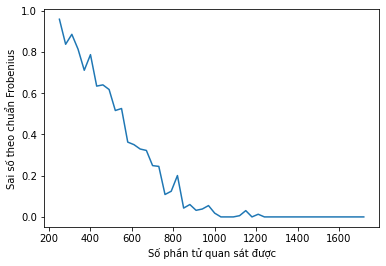

In [7]:
plt.plot(M_list,frobenius_norm_ratio_list)
plt.xlabel('Số phần tử quan sát được') 
plt.ylabel('Sai số theo chuẩn Frobenius')

In [8]:
min(frobenius_norm_ratio_list)

3.945782035594077e-09

In [9]:
frobenius_norm_ratio_list_exactly = [i for i in frobenius_norm_ratio_list if i < 1e-3 ]
len(frobenius_norm_ratio_list_exactly)


21

# Thuật Toán APG (FISTA)

In [10]:
!pip install pylops

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!pip install pyproximal

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pylops
import pyproximal

In [31]:
X=M
ny, nx = X.shape

In [32]:

frobenius_norm_ratio_list_apg=[]
time2=time.time()
for m in range(250,1750,30):
   
#     sub = m
    nsub = m
    print(m)
    iava = np.random.permutation(np.arange(ny*nx))[:nsub]
    print()
    Rop = pylops.Restriction(ny*nx, iava)
    mu = 0.0017
    # Data
    y = Rop * X.ravel()

    # Masked data
#     Y = (Rop.H * Rop * X.ravel()).reshape(ny, nx)
    
    f = pyproximal.L2(Rop, y)
    g = pyproximal.Nuclear((ny, nx), mu)

    Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                          tau=1., niter=1000, show=True)
    Xpg = Xpg.reshape(ny, nx)
    
    frobenius_norm_ratio = np.linalg.norm(Xpg-M)/np.linalg.norm(M)
    frobenius_norm_ratio_list_apg.append(frobenius_norm_ratio)
print("Thời gian chạy thuật toán FISTA",time.time()-time2)

250

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 1000	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1  -1.44454e-04   5.184e-05   2.781e-01   2.782e-01
     2  -2.88821e-04   5.185e-05   2.781e-01   2.781e-01
     3  -4.69150e-04   5.186e-05   2.780e-01   2.781e-01
     4  -6.85364e-04   5.187e-05   2.780e-01   2.780e-01
     5  -9.37366e-04   5.188e-05   2.779e-01   2.780e-01
     6  -1.22504e-03   5.189e-05   2.778e-01   2.779e-01
     7  -1.54826e-03   5.191e-05   2.778e-01   2.778e-01
     8  -1.90643e-03   5.187e-05   2.777e-01   2.777e-01
     9  -2.29893e-03   5.199e-05   2.776e-01   2.776e-01
    10  -2.72600e-03   5.196e-05   2.775e-01   2.775e-01
   101  -1.08597e-01   4.641e-05   2.575e-01   2.575e-01
   201  -2.74851e-01   4.2

   101   1.97300e-01   4.642e-05   3.344e-01   3.344e-01
   201   5.64856e-01   4.085e-05   3.098e-01   3.098e-01
   301   7.80339e-01   3.820e-05   2.967e-01   2.967e-01
   401   9.62057e-01   3.727e-05   2.898e-01   2.898e-01
   501   9.45679e-01   3.607e-05   2.863e-01   2.863e-01
   601   8.89408e-01   3.600e-05   2.844e-01   2.845e-01
   701   7.96500e-01   3.612e-05   2.833e-01   2.834e-01
   801   8.00903e-01   3.609e-05   2.825e-01   2.826e-01
   901   9.00782e-01   3.602e-05   2.820e-01   2.820e-01
   992   9.78134e-01   3.601e-05   2.817e-01   2.817e-01
   993   9.79173e-01   3.595e-05   2.817e-01   2.817e-01
   994   9.80207e-01   3.590e-05   2.817e-01   2.817e-01
   995   9.81236e-01   3.586e-05   2.817e-01   2.817e-01
   996   9.82258e-01   3.583e-05   2.817e-01   2.817e-01
   997   9.83275e-01   3.582e-05   2.817e-01   2.817e-01
   998   9.84285e-01   3.582e-05   2.817e-01   2.817e-01
   999   9.85288e-01   3.582e-05   2.817e-01   2.817e-01
  1000   9.86285e-01   3.584e-0

   401  -7.97145e-02   4.075e-05   3.073e-01   3.074e-01
   501   1.10448e-01   3.932e-05   3.022e-01   3.022e-01
   601   5.09217e-01   4.000e-05   2.992e-01   2.992e-01
   701   6.88685e-01   3.899e-05   2.977e-01   2.977e-01
   801   8.68039e-01   3.812e-05   2.969e-01   2.970e-01
   901   1.03716e+00   3.821e-05   2.965e-01   2.965e-01
   992   1.15361e+00   3.862e-05   2.963e-01   2.963e-01
   993   1.15507e+00   3.859e-05   2.963e-01   2.963e-01
   994   1.15654e+00   3.856e-05   2.963e-01   2.963e-01
   995   1.15802e+00   3.854e-05   2.963e-01   2.963e-01
   996   1.15950e+00   3.853e-05   2.962e-01   2.963e-01
   997   1.16099e+00   3.852e-05   2.962e-01   2.963e-01
   998   1.16249e+00   3.852e-05   2.962e-01   2.963e-01
   999   1.16399e+00   3.853e-05   2.962e-01   2.963e-01
  1000   1.16550e+00   3.853e-05   2.962e-01   2.963e-01

Total time (s) = 1.42
---------------------------------------------------------

520

Accelerated Proximal Gradient
----------------------------

   601   3.48652e-01   4.023e-05   3.326e-01   3.326e-01
   701   6.08308e-01   3.912e-05   3.301e-01   3.301e-01
   801   9.23857e-01   3.945e-05   3.287e-01   3.287e-01
   901   1.10630e+00   3.998e-05   3.281e-01   3.281e-01
   992   1.19290e+00   3.967e-05   3.277e-01   3.277e-01
   993   1.19407e+00   3.963e-05   3.277e-01   3.277e-01
   994   1.19523e+00   3.959e-05   3.277e-01   3.277e-01
   995   1.19640e+00   3.955e-05   3.277e-01   3.277e-01
   996   1.19758e+00   3.955e-05   3.277e-01   3.277e-01
   997   1.19876e+00   3.959e-05   3.277e-01   3.277e-01
   998   1.19995e+00   3.968e-05   3.277e-01   3.277e-01
   999   1.20116e+00   3.978e-05   3.277e-01   3.277e-01
  1000   1.20237e+00   3.988e-05   3.277e-01   3.277e-01

Total time (s) = 1.40
---------------------------------------------------------

640

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <c

   901   2.20086e+00   4.110e-05   3.444e-01   3.444e-01
   992   2.23361e+00   4.069e-05   3.439e-01   3.440e-01
   993   2.23471e+00   4.064e-05   3.439e-01   3.440e-01
   994   2.23582e+00   4.062e-05   3.439e-01   3.440e-01
   995   2.23693e+00   4.061e-05   3.439e-01   3.440e-01
   996   2.23804e+00   4.059e-05   3.439e-01   3.440e-01
   997   2.23917e+00   4.060e-05   3.439e-01   3.440e-01
   998   2.24030e+00   4.066e-05   3.439e-01   3.440e-01
   999   2.24144e+00   4.079e-05   3.439e-01   3.439e-01
  1000   2.24260e+00   4.095e-05   3.439e-01   3.439e-01

Total time (s) = 1.49
---------------------------------------------------------

760

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 1000	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
 

     6   2.34548e-04   5.092e-05   5.307e-01   5.308e-01
     7   2.95747e-04   5.092e-05   5.306e-01   5.307e-01
     8   3.63868e-04   5.094e-05   5.305e-01   5.306e-01
     9   4.38935e-04   5.095e-05   5.304e-01   5.305e-01
    10   5.20986e-04   5.096e-05   5.303e-01   5.303e-01
   101  -7.61264e-03   5.343e-05   4.934e-01   4.934e-01
   201   2.29290e-01   4.905e-05   4.446e-01   4.447e-01
   301   8.58077e-01   4.603e-05   4.096e-01   4.097e-01
   401   1.60877e+00   4.594e-05   3.863e-01   3.863e-01
   501   2.17890e+00   4.466e-05   3.714e-01   3.714e-01
   601   2.62941e+00   4.481e-05   3.628e-01   3.629e-01
   701   2.66147e+00   4.368e-05   3.579e-01   3.579e-01
   801   2.58667e+00   4.490e-05   3.558e-01   3.558e-01
   901   2.55066e+00   4.446e-05   3.552e-01   3.552e-01
   992   2.62850e+00   4.384e-05   3.551e-01   3.552e-01
   993   2.63039e+00   4.381e-05   3.551e-01   3.552e-01
   994   2.63227e+00   4.385e-05   3.551e-01   3.552e-01
   995   2.63412e+00   4.391e-0

   201  -4.63509e-01   5.039e-05   4.730e-01   4.730e-01
   301  -8.53832e-02   4.819e-05   4.278e-01   4.278e-01
   401   3.66092e-01   4.802e-05   3.976e-01   3.977e-01
   501   1.05585e+00   4.725e-05   3.785e-01   3.785e-01
   601   1.80056e+00   4.545e-05   3.672e-01   3.672e-01
   701   2.48092e+00   4.549e-05   3.610e-01   3.610e-01
   801   2.65591e+00   4.206e-05   3.591e-01   3.592e-01
   901   2.47318e+00   4.350e-05   3.576e-01   3.577e-01
   992   2.57431e+00   4.327e-05   3.572e-01   3.572e-01
   993   2.57568e+00   4.347e-05   3.572e-01   3.572e-01
   994   2.57706e+00   4.368e-05   3.572e-01   3.572e-01
   995   2.57846e+00   4.364e-05   3.572e-01   3.572e-01
   996   2.57987e+00   4.383e-05   3.572e-01   3.572e-01
   997   2.58129e+00   4.417e-05   3.571e-01   3.572e-01
   998   2.58273e+00   4.450e-05   3.571e-01   3.572e-01
   999   2.58418e+00   4.470e-05   3.571e-01   3.572e-01
  1000   2.58566e+00   4.478e-05   3.571e-01   3.572e-01

Total time (s) = 1.55
--------

   501   2.65107e+00   4.712e-05   3.795e-01   3.796e-01
   601   2.65076e+00   4.726e-05   3.673e-01   3.673e-01
   701   2.65117e+00   4.334e-05   3.612e-01   3.612e-01
   801   2.65103e+00   4.456e-05   3.591e-01   3.591e-01
   901   2.65118e+00   4.565e-05   3.582e-01   3.583e-01
   992   2.65098e+00   4.289e-05   3.574e-01   3.574e-01
   993   2.65100e+00   4.381e-05   3.574e-01   3.574e-01
   994   2.65101e+00   4.463e-05   3.574e-01   3.574e-01
   995   2.65103e+00   4.516e-05   3.574e-01   3.574e-01
   996   2.65104e+00   4.548e-05   3.574e-01   3.574e-01
   997   2.65103e+00   4.563e-05   3.574e-01   3.574e-01
   998   2.65102e+00   4.542e-05   3.574e-01   3.574e-01
   999   2.65100e+00   4.505e-05   3.573e-01   3.574e-01
  1000   2.65096e+00   4.454e-05   3.573e-01   3.574e-01

Total time (s) = 1.57
---------------------------------------------------------

1150

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <cl

   701   2.65804e+00   4.501e-05   3.606e-01   3.607e-01
   801   2.65434e+00   4.472e-05   3.586e-01   3.587e-01
   901   2.64648e+00   4.175e-05   3.576e-01   3.576e-01
   992   2.65096e+00   3.405e-05   3.570e-01   3.570e-01
   993   2.65102e+00   3.387e-05   3.570e-01   3.570e-01
   994   2.65108e+00   3.390e-05   3.569e-01   3.570e-01
   995   2.65113e+00   3.404e-05   3.569e-01   3.570e-01
   996   2.65117e+00   3.423e-05   3.569e-01   3.570e-01
   997   2.65122e+00   3.437e-05   3.569e-01   3.570e-01
   998   2.65125e+00   3.437e-05   3.569e-01   3.570e-01
   999   2.65129e+00   3.427e-05   3.569e-01   3.569e-01
  1000   2.65131e+00   3.408e-05   3.569e-01   3.569e-01

Total time (s) = 1.42
---------------------------------------------------------

1270

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	be

   992   2.65115e+00   2.783e-05   3.570e-01   3.570e-01
   993   2.65115e+00   2.772e-05   3.570e-01   3.570e-01
   994   2.65115e+00   2.757e-05   3.570e-01   3.570e-01
   995   2.65115e+00   2.738e-05   3.570e-01   3.570e-01
   996   2.65116e+00   2.718e-05   3.570e-01   3.570e-01
   997   2.65116e+00   2.697e-05   3.570e-01   3.570e-01
   998   2.65117e+00   2.670e-05   3.570e-01   3.570e-01
   999   2.65116e+00   2.647e-05   3.570e-01   3.570e-01
  1000   2.65116e+00   2.625e-05   3.570e-01   3.570e-01

Total time (s) = 1.83
---------------------------------------------------------

1390

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 1000	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   2.65112e+00   5.002e-05   6.132e-01   6.133e-01


   201   2.65099e+00   5.418e-05   4.943e-01   4.944e-01
   301   2.65097e+00   5.419e-05   4.298e-01   4.299e-01
   401   2.65096e+00   4.789e-05   3.869e-01   3.869e-01
   501   2.65161e+00   4.008e-05   3.688e-01   3.689e-01
   601   2.65143e+00   4.841e-05   3.642e-01   3.643e-01
   701   2.65128e+00   4.686e-05   3.610e-01   3.611e-01
   801   2.65137e+00   4.313e-05   3.585e-01   3.586e-01
   901   2.65125e+00   3.313e-05   3.574e-01   3.574e-01
   992   2.65129e+00   2.177e-05   3.568e-01   3.568e-01
   993   2.65127e+00   2.156e-05   3.568e-01   3.568e-01
   994   2.65125e+00   2.157e-05   3.568e-01   3.568e-01
   995   2.65128e+00   2.141e-05   3.568e-01   3.568e-01
   996   2.65131e+00   2.114e-05   3.568e-01   3.568e-01
   997   2.65131e+00   2.095e-05   3.567e-01   3.568e-01
   998   2.65130e+00   2.068e-05   3.567e-01   3.568e-01
   999   2.65128e+00   2.034e-05   3.567e-01   3.567e-01
  1000   2.65124e+00   2.002e-05   3.567e-01   3.567e-01

Total time (s) = 1.47
--------

   501   2.52959e+00   4.223e-05   3.681e-01   3.682e-01
   601   2.69936e+00   4.839e-05   3.623e-01   3.624e-01
   701   2.63240e+00   4.086e-05   3.606e-01   3.607e-01
   801   2.65557e+00   2.969e-05   3.582e-01   3.583e-01
   901   2.65119e+00   2.205e-05   3.581e-01   3.581e-01
   992   2.65146e+00   2.170e-05   3.571e-01   3.572e-01
   993   2.65144e+00   2.112e-05   3.571e-01   3.571e-01
   994   2.65142e+00   2.063e-05   3.571e-01   3.571e-01
   995   2.65139e+00   2.028e-05   3.571e-01   3.571e-01
   996   2.65135e+00   1.994e-05   3.571e-01   3.571e-01
   997   2.65126e+00   1.982e-05   3.571e-01   3.571e-01
   998   2.65118e+00   1.997e-05   3.571e-01   3.571e-01
   999   2.65112e+00   1.981e-05   3.570e-01   3.571e-01
  1000   2.65110e+00   2.037e-05   3.570e-01   3.571e-01

Total time (s) = 1.65
---------------------------------------------------------

1660

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <cl

In [35]:
frobenius_norm_ratio_list_apg[42]

0.00125304016828252

Text(0, 0.5, 'Sai số theo chuẩn Frobenius')

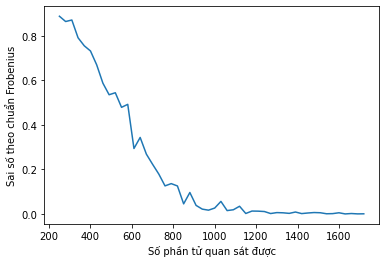

In [15]:

plt.plot(M_list,frobenius_norm_ratio_list_apg)
plt.xlabel('Số phần tử quan sát được') 
plt.ylabel('Sai số theo chuẩn Frobenius')

In [16]:
min(frobenius_norm_ratio_list_apg)

0.0004529410527022627

In [17]:
frobenius_norm_ratio_list_apg_exactly=[i for i in frobenius_norm_ratio_list_apg if i < 1e-3]
len(frobenius_norm_ratio_list_apg_exactly)

3

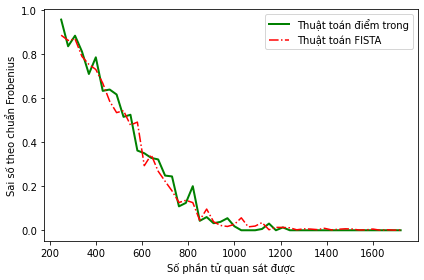

In [18]:
plt.figure()
plt.plot(M_list,frobenius_norm_ratio_list,  'g',label='Thuật toán điểm trong', linewidth=2)
plt.plot(M_list,frobenius_norm_ratio_list_apg,  'r', label='Thuật toán FISTA',linestyle='-.')
plt.xlabel('Số phần tử quan sát được') 
plt.ylabel('Sai số theo chuẩn Frobenius')
plt.legend()
plt.tight_layout()

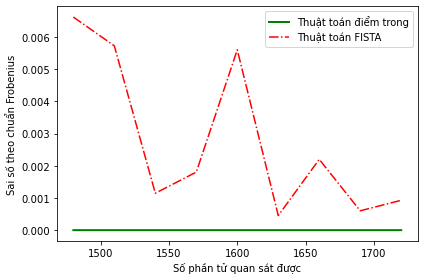

In [19]:
plt.figure()
plt.plot(M_list[41:],frobenius_norm_ratio_list[41:],  'g',label='Thuật toán điểm trong', linewidth=2)
plt.plot(M_list[41:],frobenius_norm_ratio_list_apg[41:],  'r', label='Thuật toán FISTA',linestyle='-.')
plt.xlabel('Số phần tử quan sát được') 
plt.ylabel('Sai số theo chuẩn Frobenius')
plt.legend()
plt.tight_layout()

In [20]:
len(M_list)

50